# Bayesian Data Analysis 2019 - Data Analysis Project Report

## Loaded packages

Below are the loaded packages that are used in the project. Remember to make sure that all the packages are installed into the system (for example, pystan).

In [1]:
# Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import pystan

## Description of data

The data set used is provided by UCI Machine Learning Repository.

The data set is called "Metro Interstate Traffic Volume Data Set", and it is described by the provider as follows: "Hourly Interstate 94 Westbound traffic volume for MN DoT ATR station 301, roughly midway between Minneapolis and St Paul, MN. Hourly weather features and holidays included for impacts on traffic volume."

Below we load the data from our csv file. This file is accessible at https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume 

We also take the first look at the data

In [34]:
# load data

df = pd.read_csv("Metro_Interstate_Traffic_Volume.csv")

df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [3]:
df.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000
mean,281.205870,0.334264,0.000222,49.362231,3259.818355
std,13.338232,44.789133,0.008168,39.015750,1986.860670
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,272.160000,0.000000,0.000000,1.000000,1193.000000
50%,282.450000,0.000000,0.000000,64.000000,3380.000000
75%,291.806000,0.000000,0.000000,90.000000,4933.000000
max,310.070000,9831.300000,0.510000,100.000000,7280.000000


There are many labelled data columns in our data. Below we can see the holiday, weather main and weather description labels.

In [4]:
df['holiday'].value_counts()

None                         48143
Labor Day                        7
Christmas Day                    6
Thanksgiving Day                 6
New Years Day                    6
Martin Luther King Jr Day        6
Veterans Day                     5
Memorial Day                     5
Columbus Day                     5
Washingtons Birthday             5
Independence Day                 5
State Fair                       5
Name: holiday, dtype: int64

In [5]:
df['weather_main'].value_counts()

Clouds          15164
Clear           13391
Mist             5950
Rain             5672
Snow             2876
Drizzle          1821
Haze             1360
Thunderstorm     1034
Fog               912
Smoke              20
Squall              4
Name: weather_main, dtype: int64

In [6]:
df['weather_description'].value_counts()

sky is clear                           11665
mist                                    5950
overcast clouds                         5081
broken clouds                           4666
scattered clouds                        3461
light rain                              3372
few clouds                              1956
light snow                              1946
Sky is Clear                            1726
moderate rain                           1664
haze                                    1360
light intensity drizzle                 1100
fog                                      912
proximity thunderstorm                   673
drizzle                                  651
heavy snow                               616
heavy intensity rain                     467
snow                                     293
proximity shower rain                    136
thunderstorm                             125
heavy intensity drizzle                   64
thunderstorm with heavy rain              63
thundersto

Let's look at the data that we have in quantified form. First the traffic volume. This data seems good. There are no clear outliers.

Text(0.5, 1.0, 'Traffic volume')

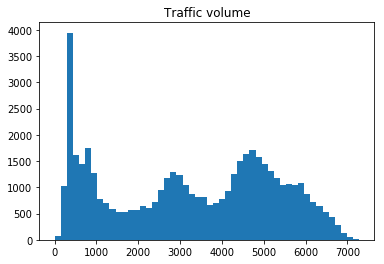

In [7]:
plt.hist(df['traffic_volume'], bins=50)
plt.title("Traffic volume")

From the temperature data we can see that there are clear outliers. The x-axel is scaled from 0 to 300 even though there are barely any values below 250. When we dig deeper below the 250 values, we can see there are a couple of really low values. 

Text(0.5, 1.0, 'Temperature')

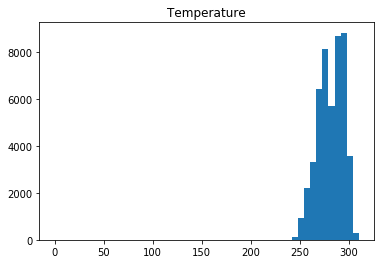

In [8]:
plt.hist(df['temp'], bins=50)
plt.title("Temperature")

Text(0.5, 1.0, 'Low temperatures')

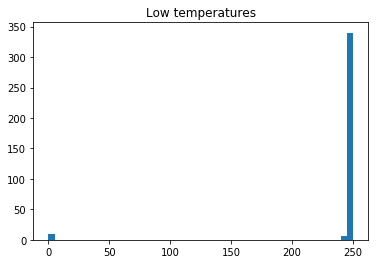

In [9]:
df_low_temp = df[df['temp'] < 250]
plt.hist(df_low_temp['temp'], bins=50)
plt.title("Low temperatures")

In [10]:
df[df['temp'] == 0]

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
11898,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-01-31 03:00:00,361
11899,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-01-31 04:00:00,734
11900,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-01-31 05:00:00,2557
11901,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-01-31 06:00:00,5150
11946,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-02-02 03:00:00,291
11947,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-02-02 04:00:00,284
11948,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-02-02 05:00:00,434
11949,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-02-02 06:00:00,739
11950,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-02-02 07:00:00,962
11951,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-02-02 08:00:00,1670


When we look at these zero Kelvin temperatures, we can see that the observations seem otherwise correct. The sky is clear, there is no rain or snow, and there are some small amounts of traffic during that time. Thus, we suggest that these datapoints only lack the temperature data and can still be used. We will fix the points by taking the average temperature during similar times (Jan-Feb nights).

Next off is the rain. We can see again that there are some outliers. When we take the description of our data, we see there is a datapoint with around 9831 mm of rain. Otherwise, the data seems reasonable. There are some 50mm rain points, but this is still realistic within one hour of really heavy rain. We will set the 9831mm datapoint to an average of our very heavy rain weather descriptions

Text(0.5, 1.0, 'Rain')

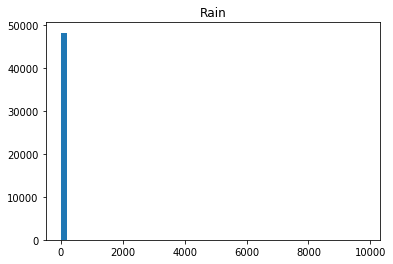

In [11]:
plt.hist(df['rain_1h'], bins=50)
plt.title("Rain")

In [12]:
df[df['weather_description'] == 'very heavy rain']

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
7133,None,291.76,16.38,0.0,76,Rain,very heavy rain,2013-06-22 05:00:00,635
7179,None,295.82,44.45,0.0,76,Rain,very heavy rain,2013-06-24 11:00:00,4802
7664,None,292.82,19.90,0.0,20,Rain,very heavy rain,2013-07-14 05:00:00,542
7667,None,292.65,25.32,0.0,8,Rain,very heavy rain,2013-07-14 06:00:00,958
7670,None,292.87,21.42,0.0,90,Rain,very heavy rain,2013-07-14 07:00:00,1745
8247,None,289.10,55.63,0.0,68,Rain,very heavy rain,2013-08-07 02:00:00,315
10734,None,262.65,18.80,0.0,64,Rain,very heavy rain,2013-12-16 19:00:00,2755
10806,None,264.50,28.70,0.0,64,Rain,very heavy rain,2013-12-19 23:00:00,1190
14853,None,298.21,18.03,0.0,0,Rain,very heavy rain,2014-06-02 16:00:00,6443
16300,None,294.87,23.80,0.0,90,Rain,very heavy rain,2015-07-06 03:00:00,346


Text(0.5, 1.0, 'Corrected rain')

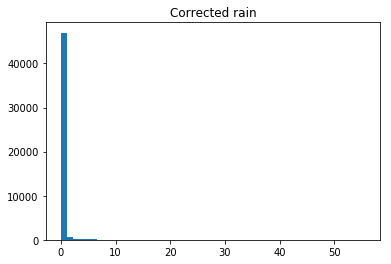

In [13]:
df_rain = df[df['rain_1h'] < 9831]
plt.hist(df_rain['rain_1h'], bins=50)
plt.title("Corrected rain")

With snow and clouds, the data seems to be correct. There are a lot of datapoints with 0 snow, but there are also a lot of points where there are similar looking numbers of snow. With clouds, the data is quite dispersed.

Text(0.5, 1.0, 'Snow')

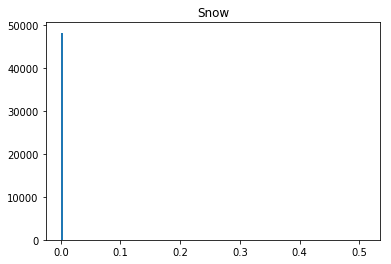

In [14]:
plt.hist(df['snow_1h'], bins=150)
plt.title("Snow")

Text(0.5, 1.0, 'Clouds')

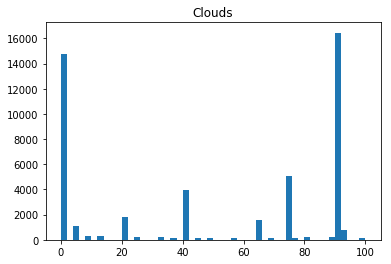

In [15]:
plt.hist(df['clouds_all'], bins=50)
plt.title("Clouds")

In [16]:
# daytime-specific traffic data:
import datetime

# convert date_time-field into datetime format & add index
df_with_dates = df
df_with_dates['date_time'] = pd.to_datetime(df['date_time'], format='%Y-%m-%d %H:%M:%S')
df_with_dates = df_with_dates.set_index('date_time')
df_with_dates['weekday'] = df_with_dates.index.dayofweek
df_with_dates.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume,weekday
date_time,,,,,,,,,
2012-10-02 09:00:00,None,288.28,0.0,0.0,40,Clouds,scattered clouds,5545,1
2012-10-02 10:00:00,None,289.36,0.0,0.0,75,Clouds,broken clouds,4516,1
2012-10-02 11:00:00,None,289.58,0.0,0.0,90,Clouds,overcast clouds,4767,1
2012-10-02 12:00:00,None,290.13,0.0,0.0,90,Clouds,overcast clouds,5026,1
2012-10-02 13:00:00,None,291.14,0.0,0.0,75,Clouds,broken clouds,4918,1


Text(0.5, 1.0, 'Traffic at 12:00')

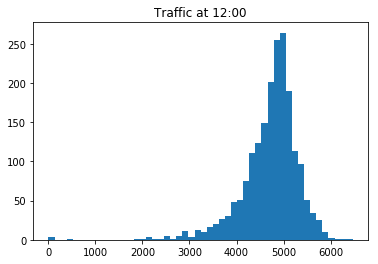

In [17]:
plt.hist(df_with_dates.between_time('11:45','12:15')['traffic_volume'], bins=50)
plt.title("Traffic at 12:00")

In [92]:
def traffic_at_time(time):
    return df_with_dates.at_time('{}:00'.format(time))['traffic_volume']

# inefficient, but makes testing easier
traffic_by_time = [traffic_at_time(time) for time in range(24)]

# e.g. traffic volume at 12
min_n = min(len(traffic_by_time[n]) for n in range(24))

traffic_by_time = [traffic_by_time[n][:min_n] for n in range(24)]

## Description of data analysis problem

Based on the visualizations of the traffic data, we find that there are multiple peaks in traffic volume. Our hypothesis is that the total traffic volume at any given time is largely dictated by the time of day.

Thus, our data analysis problem is to analyze the differences in traffic caused by the time of the day.

## Description of models

For the data analysis problem, we chose to use hierarchical and pooled models.

### Hierarchical model

// kuvailua

### Pooled model // onks täl joku täsmällisempi nimi?

// lisää kuvailua

## Prior choices

// priorivalintojen perusteleminen tässä

Informative vai weakly informative?

Perustuu luultavasti aikasempaan visuaaliseen tulkintaan noista jakaumista


## The model and training

Next off we are going to introduce our model and train it using STAN.

This model is a modified version of "Comparison of k groups with common variance (ANOVA)" accessed on 06/12/19 from http://avehtari.github.io/BDA_R_demos/demos_rstan/rstan_demo.html#8_comparison_of_k_groups_with_hierarchical_models

In [18]:
pooled_model = """
data {
    int<lower=0> N;
    vector[N] y;
}
    parameters {
    real mu;
    real<lower=0> sigma;
}
model {
    y ~ normal(mu, sigma);
}
generated quantities {
    real ypred;
    vector[N] log_lik;
    ypred = normal_rng(mu, sigma);
    for (i in 1:N)
        log_lik[i] = normal_lpdf(y[i] | mu, sigma);
}

"""

In [65]:
factory_data = np.array([
    [ 83, 117, 101, 105,  79,  57],
    [ 92, 109,  93, 119,  97,  92],
    [ 92, 114,  92, 116, 103, 104],
    [ 46, 104,  86, 102,  79,  77],
    [ 67,  87,  67, 116,  92, 100]], dtype=int)
factory_data.flatten()

array([ 83, 117, 101, 105,  79,  57,  92, 109,  93, 119,  97,  92,  92,
       114,  92, 116, 103, 104,  46, 104,  86, 102,  79,  77,  67,  87,
        67, 116,  92, 100])

In [90]:
pooled_stan = pystan.StanModel(model_code=pooled_model)

flattened_factory_data = traffic_by_time[9]

pooled_data= {
    "N": len(flattened_factory_data),
    "y": flattened_factory_data
}

pooled_fit = pooled_stan.sampling(data=pooled_data)

pooled_samples = pooled_fit.extract(permuted=True)

pooled_samples

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_38e49d0b14fc415bc533c17a1e9150d1 NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


OrderedDict([('mu',
              array([4412.79727896, 4389.48211284, 4401.96269848, ..., 4345.22791982,
                     4381.38064443, 4370.63068929])),
             ('sigma',
              array([1048.82243144, 1044.2777012 , 1080.85165575, ..., 1052.64577677,
                     1050.33010404, 1042.03585613])),
             ('ypred',
              array([5124.64304827, 4613.22447426, 4791.07627697, ..., 4432.98946084,
                     2749.73446718, 3157.08204974])),
             ('log_lik',
              array([[-8.45702085, -8.38334549, -8.2394339 , ..., -8.74474608,
                      -9.39454952, -7.88799749],
                     [-8.48221647, -8.40631631, -8.25768584, ..., -8.7186596 ,
                      -9.36461719, -7.88772615],
                     [-8.46363212, -8.39357225, -8.25656102, ..., -8.71122343,
                      -9.31895876, -7.91893916],
                     ...,
                     [-8.52753626, -8.44988262, -8.29713584, ..., -8.65975025,



### Equations

Equations should be correctly formated using LaTeX or being included as images if, for example, Microsoft Equations is used. 

In Markdown, equations can easily be formulated using LaTeX in line as $f(k) = {n \choose k} p^{k} (1-p)^{n-k}$ or use the math environment as follows:

$$\begin{array}{ccc}
x_{11} & x_{12} & x_{13}\\
x_{21} & x_{22} & x_{23}
\end{array}$$

If you are new to LaTeX equations, you could use the [latext4technics](https://www.latex4technics.com/) equation editor to create LaTeX equations to include in the report.

More information on using LaTeX in R markdown can be found in 2.5.3 in [R Markdown: The Definite Guide](https://bookdown.org/yihui/rmarkdown/).

A short introduction to equations in LaTeX can be found [here](https://www.overleaf.com/learn/latex/Mathematical_expressions).

(array([  1.,   0.,   0.,   1.,   3.,   5.,   2.,   7.,   5.,   9.,  22.,
         27.,  34.,  65.,  59.,  91.,  96., 121., 166., 185., 198., 221.,
        244., 232., 268., 239., 248., 225., 233., 170., 159., 144., 123.,
         91.,  83.,  53.,  45.,  38.,  30.,  19.,  10.,   5.,   6.,   5.,
          3.,   1.,   3.,   2.,   1.,   2.]),
 array([ 225.61750291,  392.73881574,  559.86012856,  726.98144139,
         894.10275421, 1061.22406704, 1228.34537986, 1395.46669269,
        1562.58800551, 1729.70931834, 1896.83063116, 2063.95194398,
        2231.07325681, 2398.19456963, 2565.31588246, 2732.43719528,
        2899.55850811, 3066.67982093, 3233.80113376, 3400.92244658,
        3568.04375941, 3735.16507223, 3902.28638506, 4069.40769788,
        4236.52901071, 4403.65032353, 4570.77163636, 4737.89294918,
        4905.01426201, 5072.13557483, 5239.25688766, 5406.37820048,
        5573.49951331, 5740.62082613, 5907.74213896, 6074.86345178,
        6241.9847646 , 6409.10607743, 6576.227

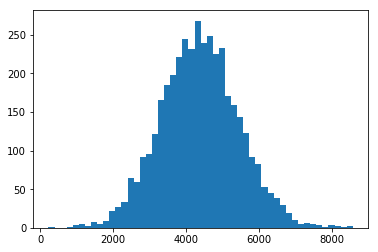

In [91]:
plt.hist(pooled_samples['ypred'], bins=50)